In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Loading Dataset....**

In [2]:
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 0s 0us/step


# **Data Visualization**

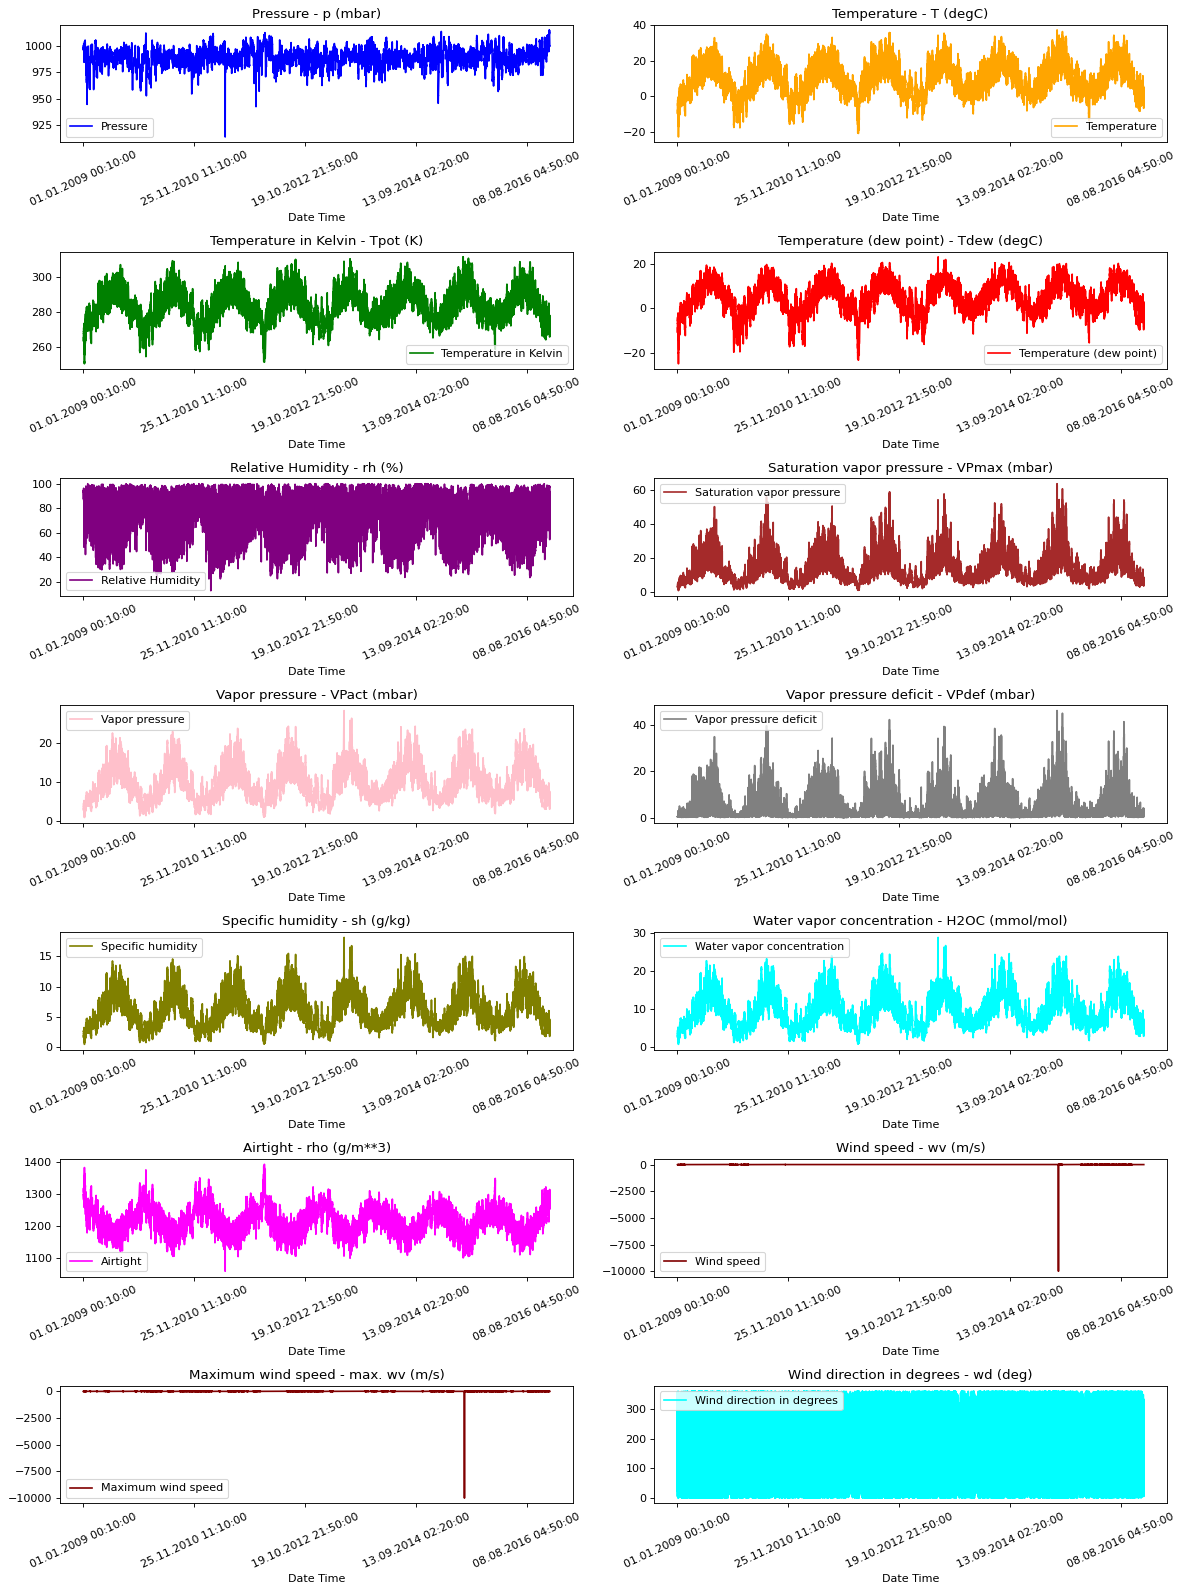

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

titles = [
    "Pressure", "Temperature", "Temperature in Kelvin", "Temperature (dew point)",
    "Relative Humidity", "Saturation vapor pressure", "Vapor pressure",
    "Vapor pressure deficit", "Specific humidity", "Water vapor concentration",
    "Airtight", "Wind speed", "Maximum wind speed", "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)",
    "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)",
    "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)",
]

colors = [
    "blue", "orange", "green", "red", "purple",
    "brown", "pink", "gray", "olive", "cyan", "magenta","maroon","maroon", "cyan"
]

date_time_key = "Date Time"


def plot_single_feature(ax, title, key, color, time_data, data):
    t_data = data[key]
    t_data.index = time_data
    t_data.plot(ax=ax, color=color, title="{} - {}".format(title, key), rot=25)
    ax.legend([title])


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i, (title, key, color) in enumerate(zip(titles, feature_keys, colors)):
        plot_single_feature(axes[i // 2, i % 2], title, key, color, time_data, data)
    plt.tight_layout()


# Assuming 'df' is your DataFrame
show_raw_visualization(df)


# **Data Preprocessing**

In [4]:
import numpy as np

split_fraction = 0.715
train_split = int(split_fraction * len(df))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize_data(data, train_split):
    data_mean = np.mean(data[:train_split], axis=0)
    data_std = np.std(data[:train_split], axis=0)
    normalized_data = (data - data_mean) / data_std
    return normalized_data


In [5]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize_data(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


# **Train the dataset**

In [6]:
start = past + future
end = start + train_split

# Assuming 'train_data' and 'normalized_features' are available

# Extracting input features (x_train) and target variable (y_train)
x_train = train_data.iloc[start:end, :7].values
y_train = features.iloc[start:end, 1].values.reshape(-1, 1)

sequence_length = int(past / step)

# Printing the shapes for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("Sequence length:", sequence_length)


x_train shape: (299901, 7)
y_train shape: (300693, 1)
Sequence length: 120


In [7]:
start = past + future
end = start + train_split

# Assuming 'train_data', 'features', 'past', 'future', and 'step' are available

x_train = train_data.iloc[start:end, :7].values
y_train = features.iloc[start:end, 1].values.reshape(-1, 1)

sequence_length = int(past / step)

In [8]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [9]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


# **Training**

In [10]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming 'model', 'dataset_train', 'epochs', and 'dataset_val' are available

path_checkpoint = "model_checkpoint.weights.h5"

es_callback = EarlyStopping(monitor="val_loss", min_delta=0, patience=7)

modelckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/10
1169/1169 [==============================] - ETA: 0s - loss: 0.4010
Epoch 1: val_loss improved from inf to 0.36871, saving model to model_checkpoint.weights.h5
1169/1169 [==============================] - 37s 29ms/step - loss: 0.4010 - val_loss: 0.3687
Epoch 2/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3603
Epoch 2: val_loss did not improve from 0.36871
1169/1169 [==============================] - 34s 29ms/step - loss: 0.3603 - val_loss: 0.3781
Epoch 3/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3529
Epoch 3: val_loss did not improve from 0.36871
1169/1169 [==============================] - 33s 29ms/step - loss: 0.3529 - val_loss: 0.3741
Epoch 4/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3454
Epoch 4: val_loss did not improve from 0.36871
1169/1169 [==============================] - 33s 28ms/step - loss: 0.3454 - val_loss: 0.3836
Epoch 5/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3362


**# Evaluate the Model**

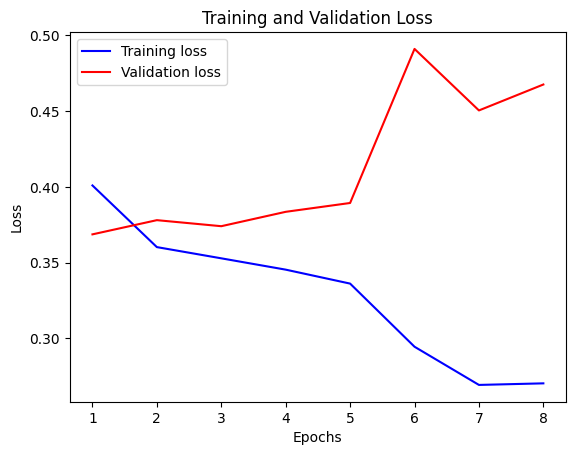

In [12]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")


# **Prediction**

8/8 [==============================] - 0s 3ms/step


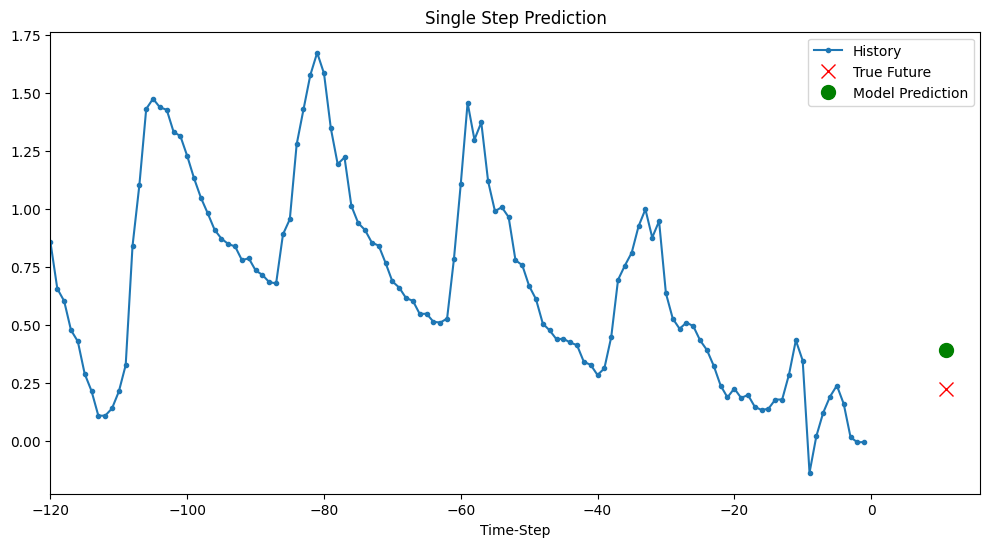

8/8 [==============================] - 0s 3ms/step


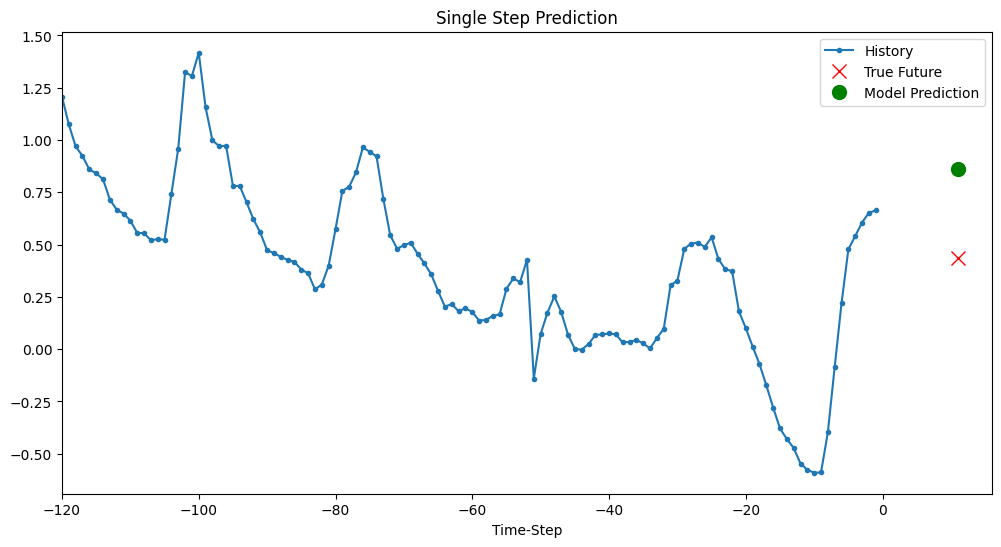

8/8 [==============================] - 0s 3ms/step


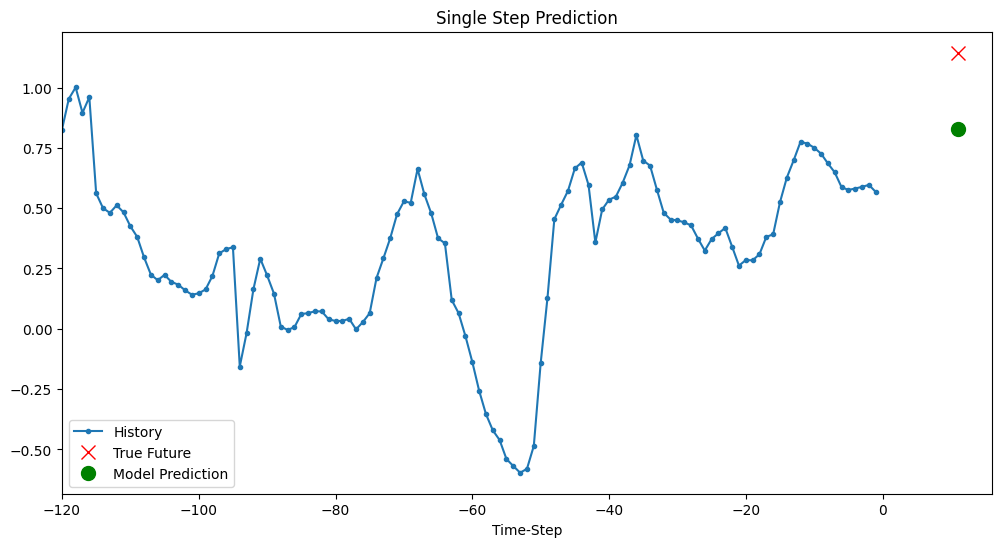

8/8 [==============================] - 0s 3ms/step


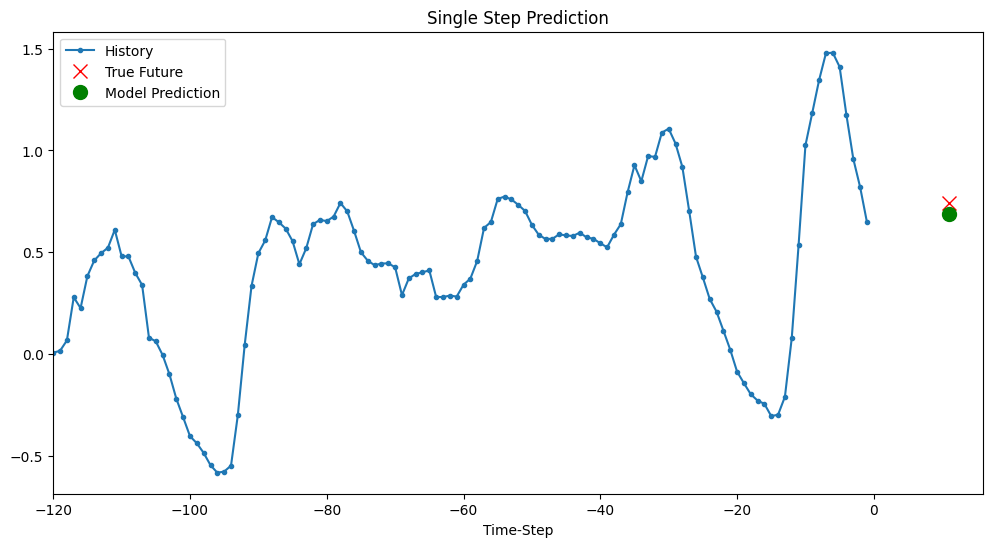

8/8 [==============================] - 0s 3ms/step


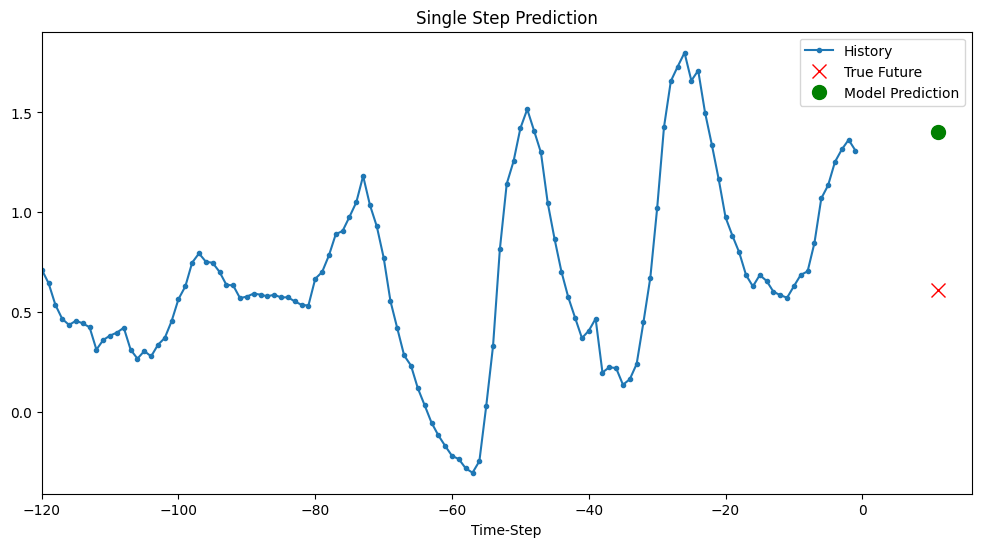

In [13]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0

    plt.figure(figsize=(12, 6))
    plt.title(title)

    for i, val in enumerate(plot_data):
        if i:
            plt.plot(time_steps[-1] + future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], time_steps[-1] + future + 5])
    plt.xlabel("Time-Step")
    plt.show()

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )
